# Comparison of Static Grewe et. al Feature Values

Comparison of feature distributions of **benchmarks** (the 275 GPGPU OpenCL kernels used in CGO'17), **clgen**, and **github** (the subset of the training corpus that we can extract features from).

In [1]:
from absl import flags
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sql
from labm8 import viz
from labm8 import labtypes
from experimental.deeplearning.clgen.closeness_to_grewe_features import grewe_features_db
from experimental.deeplearning.clgen.closeness_to_grewe_features.grewe_features_db import \
    OpenCLKernelWithRawGreweFeatures as Table

FLAGS = flags.FLAGS(['argv0'])

db = grewe_features_db.Database('file:///var/phd/db/cc1.mysql?grewe_kernels?charset=utf8')

In [2]:
FEATURES = [
    ('grewe_compute_operation_count', Table.grewe_compute_operation_count),
    ('grewe_global_memory_access_count', Table.grewe_global_memory_access_count),
    ('grewe_local_memory_access_count', Table.grewe_local_memory_access_count),
    ('grewe_coalesced_memory_access_count', Table.grewe_coalesced_memory_access_count),
    # ('grewe_rational_operation_count', Table.grewe_rational_operation_count),
    ('F1_compute_mem_sum', Table.grewe_compute_operation_count + 
     Table.grewe_global_memory_access_count),
    ('F2_coalesced_mem_ratio', Table.grewe_coalesced_memory_access_count /
                (Table.grewe_global_memory_access_count + float(1))),
    ('F3_local_global_mem_ratio', Table.grewe_local_memory_access_count /
            (Table.grewe_global_memory_access_count + float(1))),
    ('F4_compute_mem_ratio', Table.grewe_compute_operation_count /
                (Table.grewe_global_memory_access_count + float(1))),
]

RAW_FEATURES = [(f, _) for f, _ in FEATURES if f.startswith('grewe_')]
COMBINED_FEATURES = [(f, _) for f, _ in FEATURES if f.startswith('F')]
assert len(RAW_FEATURES) + len(COMBINED_FEATURES) == len(FEATURES)

def CombineOrigins(df):
    """Strip '_' suffix from origins."""
    df['original_origin'] = df['origin']
    df['origin'] = [x.split('_')[0] for x in df['origin']]
    return df

def StripNonBenchmarkDuplicates(df):
    """Remove duplicate feature values from the """
    benchmarks = df[df['origin'] == 'benchmarks']
    others = df[df['origin'] != 'benchmarks'].drop_duplicates(subset=[f for f, _ in RAW_FEATURES] + ['origin'])
    return pd.concat((benchmarks, others)).reset_index(drop=True)

def AppendLogFeatureColumns(df):
    for feature, _ in FEATURES:
        df[f'log_{feature}'] = np.log1p(df[feature])
    return df

def AppendNormalizedFeatureColumns(df):
    """Normalize each column (independently) to the max value from the benchmarks."""
    for feature, _ in FEATURES:
        benchmark_max = df[df['origin'] == 'benchmarks'][feature].max()
        df[f'norm_{feature}'] = df[feature] / benchmark_max
    return df

def ReadDataFrame():
    with db.Session() as s:
        df = pd.read_sql(
            s.query(
                *[feature for _, feature in FEATURES],
                sql.func.char_length(Table.src),
                Table.origin
            ).statement, s.bind)
    df.columns = [name for name, _ in FEATURES] + ['charlen', 'origin']
    df = CombineOrigins(df)
    row_count = len(df)
    df = StripNonBenchmarkDuplicates(df)
    uniq_row_count = len(df)
    print(f'{row_count} rows produced {uniq_row_count} ({uniq_row_count/row_count:.2%}) unique rows')
    df = AppendLogFeatureColumns(df)
    df = AppendNormalizedFeatureColumns(df)
    return df

df = ReadDataFrame()

benchmarks_only_df = df[df['origin'] == 'benchmarks']

df.groupby('origin').count()[['grewe_compute_operation_count',]]

110181 rows produced 4286 (3.89%) unique rows


,grewe_compute_operation_count
origin,
benchmarks,275
clgen,2742
github,1269


## Combined Features (except dynamic values)

We exclude dynamic values since we can set them arbitrarily, ensuring we could match any distribution.

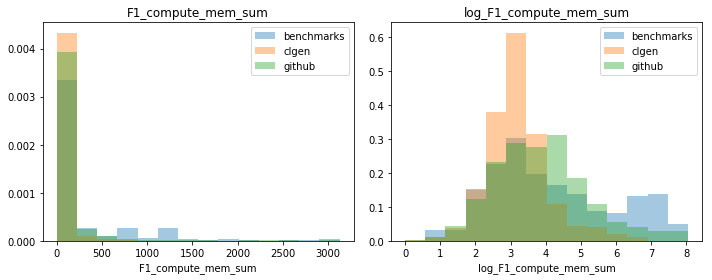

F1_compute_mem_sum
benchmarks       n=275, mean=288.87, stdev=529.62, percentiles=[0%=1 50%=44 95%=1268 99%=2659 100%=3128]
clgen            n=2742, mean=42.01, stdev=80.77, percentiles=[0%=0 50%=22 95%=148 99%=478 100%=832]
github           n=1269, mean=429.10, stdev=1631.86, percentiles=[0%=0 50%=46 95%=2274 99%=7012 100%=19057]



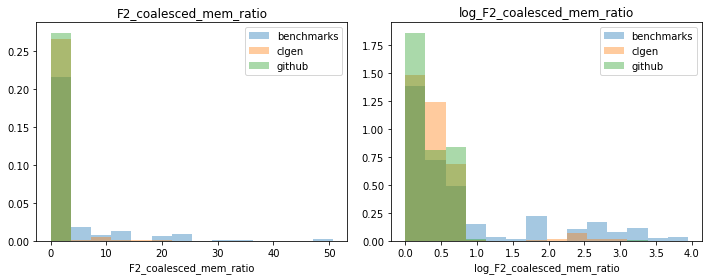

F2_coalesced_mem_ratio
benchmarks       n=275, mean=3.17, stdev=7.73, percentiles=[0%=0 50%=0 95%=19 99%=37 100%=50]
clgen            n=2742, mean=0.39, stdev=2.12, percentiles=[0%=0 50%=0 95%=0 99%=11 100%=20]
github           n=1269, mean=0.07, stdev=1.15, percentiles=[0%=0 50%=0 95%=0 99%=1 100%=28]



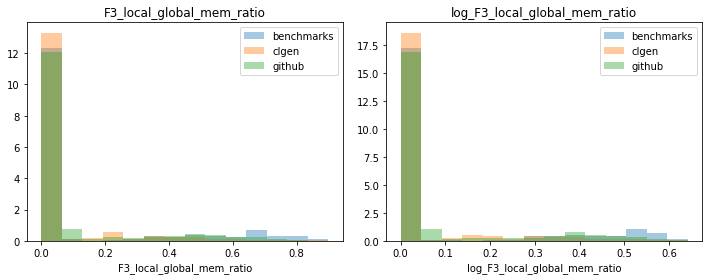

F3_local_global_mem_ratio
benchmarks       n=275, mean=0.00, stdev=0.00, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=0]
clgen            n=2742, mean=0.00, stdev=0.00, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=0]
github           n=1269, mean=0.00, stdev=0.00, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=0]



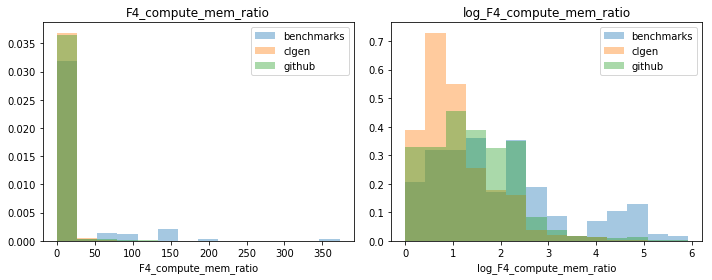

F4_compute_mem_ratio
benchmarks       n=275, mean=22.38, stdev=49.88, percentiles=[0%=0 50%=4 95%=139 99%=209 100%=372]
clgen            n=2742, mean=3.06, stdev=7.97, percentiles=[0%=0 50%=1 95%=9 99%=40 100%=138]
github           n=1269, mean=12.28, stdev=91.24, percentiles=[0%=0 50%=2 95%=17 99%=124 100%=1921]



In [3]:
HUE_ORDER = ['benchmarks', 'clgen', 'github']

for name, val in COMBINED_FEATURES:
    bins = np.linspace(min(df[name]), max(benchmarks_only_df[name]), 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    viz.Distplot(x=name, hue='origin', data=df, bins=bins,
                 norm_hist=True, ax=ax, hue_order=HUE_ORDER)
    plt.legend()
    plt.title(name)

    ax = fig.add_subplot(1, 2, 2)    
    bins = np.linspace(min(df[f'log_{name}']), max(benchmarks_only_df[f'log_{name}']), 15)
    viz.Distplot(x=f'log_{name}', hue='origin', data=df, bins=bins, 
                 norm_hist=True, ax=ax, hue_order=HUE_ORDER)
    plt.legend()
    plt.title(f'log_{name}')
    viz.Finalize(figsize=(10, 4))
    
    print(name)
    for group in sorted(set(df['origin'])):
        print(f'{group:16s}', viz.SummarizeInts(df[df['origin'] == group][name]))
    print()

## Raw Feature Values

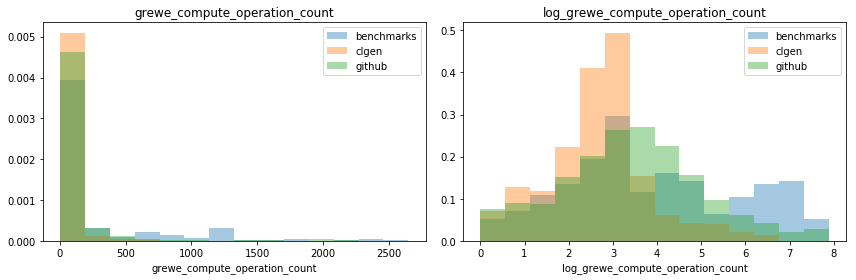

grewe_compute_operation_count
benchmarks   n=275, mean=261.52, stdev=479.34, percentiles=[0%=0 50%=32 95%=1260 99%=2229 100%=2650]
clgen        n=2742, mean=31.69, stdev=72.94, percentiles=[0%=0 50%=14 95%=129 99%=428 100%=738]
github       n=1269, mean=382.32, stdev=1483.86, percentiles=[0%=0 50%=33 95%=2028 99%=6307 100%=17145]



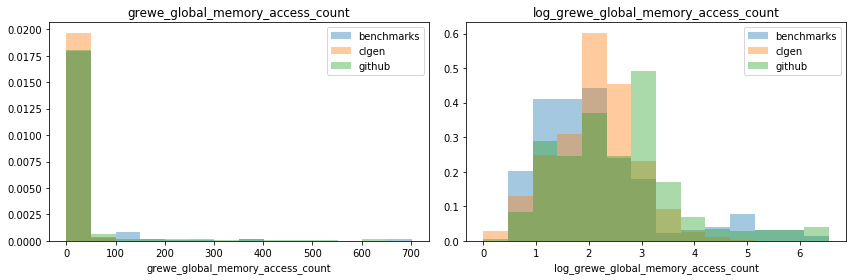

grewe_global_memory_access_count
benchmarks   n=275, mean=27.35, stdev=79.23, percentiles=[0%=1 50%=6 95%=147 99%=387 100%=702]
clgen        n=2742, mean=10.32, stdev=10.58, percentiles=[0%=0 50%=8 95%=28 99%=58 100%=124]
github       n=1269, mean=46.78, stdev=160.06, percentiles=[0%=0 50%=11 95%=227 99%=659 100%=1912]



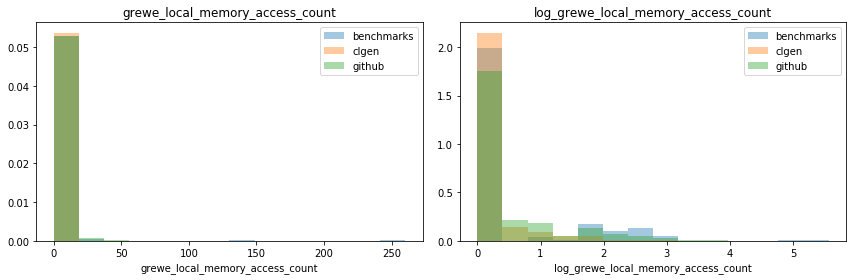

grewe_local_memory_access_count
benchmarks   n=275, mean=3.16, stdev=17.83, percentiles=[0%=0 50%=0 95%=13 99%=21 100%=260]
clgen        n=2742, mean=0.51, stdev=2.65, percentiles=[0%=0 50%=0 95%=3 99%=9 100%=54]
github       n=1269, mean=1.82, stdev=8.33, percentiles=[0%=0 50%=0 95%=8 99%=25 100%=225]



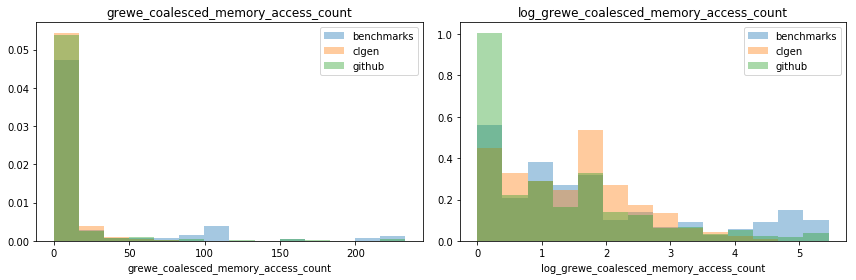

grewe_coalesced_memory_access_count
benchmarks   n=275, mean=23.63, stdev=49.08, percentiles=[0%=0 50%=3 95%=112 99%=232 100%=233]
clgen        n=2742, mean=6.45, stdev=10.32, percentiles=[0%=0 50%=3 95%=23 99%=54 100%=123]
github       n=1269, mean=36.93, stdev=159.87, percentiles=[0%=0 50%=2 95%=219 99%=653 100%=1912]



In [4]:
for feature, _ in RAW_FEATURES:
    bins = np.linspace(min(df[feature]), max(benchmarks_only_df[feature]), 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    viz.Distplot(x=feature, hue='origin', data=df, bins=bins,
                 norm_hist=True, ax=ax, hue_order=HUE_ORDER)
    plt.legend()
    plt.title(feature)

    ax = fig.add_subplot(1, 2, 2)    
    bins = np.linspace(min(df[f'log_{feature}']), max(benchmarks_only_df[f'log_{feature}']), 15)
    viz.Distplot(x=f'log_{feature}', hue='origin', data=df, bins=bins, 
                 norm_hist=True, ax=ax, hue_order=HUE_ORDER)
    plt.legend()
    plt.title(f'log_{feature}')
    viz.Finalize(figsize=(12, 4))
    
    print(feature)
    for group in sorted(set(df['origin'])):
        print(f'{group:12s}', viz.SummarizeInts(df[df['origin'] == group][feature]))
    print()

## Feature Distances

In [5]:
def GetFeatureValues(df, features, origin):
    subdf = df[df['origin'] == origin]
    return subdf[features].values

def GetMinimumDistances(df, features, origin):
    target_values = GetFeatureValues(df, features, 'benchmarks')
    other_values = GetFeatureValues(df, features, origin)
    all_distances = scipy.spatial.distance.cdist(target_values, other_values,
                                                 metric='euclidean')
    min_distances = np.amin(all_distances, axis=1)
    return min_distances

def GetFeatureComparison(df, features):    
    clgen_distances = GetMinimumDistances(df, features, 'clgen')
    github_distances = GetMinimumDistances(df, features, 'github')
    distance_pairs = np.vstack([clgen_distances, github_distances]).T
    n = len(clgen_distances)
    
    # Count distances.
    distances_equal = (distance_pairs[:,0] == distance_pairs[:,1]).sum()
    clgen_better = (distance_pairs[:,0] < distance_pairs[:,1]).sum()
    clgen_worse = (distance_pairs[:,0] > distance_pairs[:,1]).sum()
    clgen_equal_or_better = clgen_better + distances_equal
   
    # Sanity check.
    assert sum([distances_equal, clgen_better, clgen_worse]) == n

    return {
        'clgen_win_or_draw_ratio': f'{clgen_equal_or_better / n:.2%}', # clgen_equal_or_better / n,
        'clgen_win_count': clgen_better,
        'clgen_draw_count': distances_equal,
        'clgen_loss_count': clgen_worse,
    }

rows = []

for feature, _ in RAW_FEATURES:     
    rows.append(labtypes.update({ 'feature': feature }, GetFeatureComparison(df, [feature,])))
    
for feature, _ in COMBINED_FEATURES:     
    rows.append(labtypes.update({ 'feature': feature }, GetFeatureComparison(df, [feature,])))

norm_raw_features = [f'norm_{f}' for f, _ in RAW_FEATURES]
norm_combined_features = [f'norm_{f}' for f, _ in COMBINED_FEATURES]

rows.append(labtypes.update(
    { 'feature': 'ALL_raw_features' }, GetFeatureComparison(df, norm_raw_features)))
rows.append(labtypes.update(
    { 'feature': 'ALL_combined_features' }, GetFeatureComparison(df, norm_combined_features)))
    
pd.DataFrame(rows, columns=[
    'feature', 
    'clgen_win_or_draw_ratio', 
    'clgen_win_count',
    'clgen_draw_count',
    'clgen_loss_count',
])

,feature,clgen_win_or_draw_ratio,clgen_win_count,clgen_draw_count,clgen_loss_count
0,grewe_compute_operation_count,76.36%,19,191,65
1,grewe_global_memory_access_count,91.64%,3,249,23
2,grewe_local_memory_access_count,97.82%,0,269,6
3,grewe_coalesced_memory_access_count,86.91%,3,236,36
4,F1_compute_mem_sum,83.27%,31,198,46
5,F2_coalesced_mem_ratio,87.27%,64,176,35
6,F3_local_global_mem_ratio,92.73%,4,251,20
7,F4_compute_mem_ratio,75.64%,64,144,67
8,ALL_raw_features,52.36%,83,61,131
9,ALL_combined_features,45.09%,68,56,151


### Comparison of closest distances

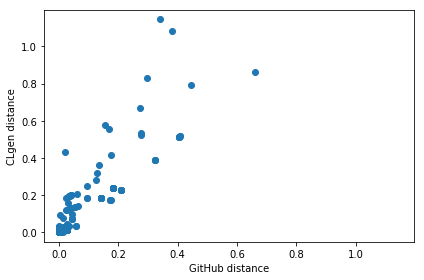

In [6]:
clgen_distances = GetMinimumDistances(df, norm_raw_features, 'clgen')
github_distances = GetMinimumDistances(df, norm_raw_features, 'github')
plt.scatter(github_distances, clgen_distances)
plt.xlabel('GitHub distance')
plt.ylabel('CLgen distance')
padding = 0.05
plt.xlim((-padding, max(max(clgen_distances), max(github_distances)) + padding))
plt.ylim((-padding, max(max(clgen_distances), max(github_distances)) + padding))
viz.Finalize()

### Distances as a function of CLgen corpus size

Rate at which CLgen-generated programs beat 1269 GitHub kernels at closeness to 275 benchmarks


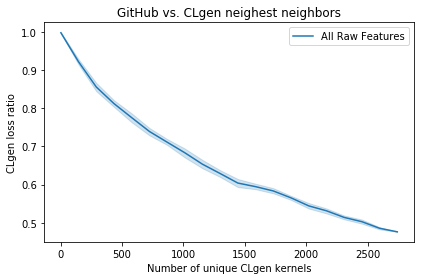

In [7]:
def SampleFractionOfClgenRows(df: pd.DataFrame, frac: float):
    clgen = df[df['origin'] == 'clgen']
    github = df[df['origin'] == 'github']
    other = df[(df['origin'] != 'clgen') & (df['origin'] != 'github')]
    clgen_subset = clgen.sample(frac=frac)
    clgen_max_len = max(clgen_subset['charlen'])
    # Clip the length of GitHub kernels to match that of CLgen.
    github_clipped = github[github['charlen'] <= clgen_max_len]
    return (
        len(clgen_subset), 
        pd.concat((other, clgen_subset, github_clipped)),
        pd.concat((other, clgen_subset, github)),
    )

n_benchmarks = len(benchmarks_only_df)
n_github = len(df[df['origin'] == 'github'])

def GetWinRate(n, df, features, label):
    vals = GetFeatureComparison(df, features)
    return {
        'x': n, 
        'y': (n_benchmarks - (vals['clgen_win_count'] + vals['clgen_draw_count'])) / n_benchmarks,
        'label': label,
    }

experiment_df = []
for frac in np.linspace(0.001, 1.0, 20):
    for _ in range(30):
        n, df_subset, df_subset2 = SampleFractionOfClgenRows(df, frac)
#         for feature, _ in FEATURES:
#             experiment_df.append(GetWinRate(n, df_subset2, [feature], feature))
        experiment_df.append(GetWinRate(n, df_subset2, norm_raw_features, 'All Raw Features'))
#         experiment_df.append(GetWinRate(n, df_subset2, norm_combined_features, 'All Combined Features'))

experiment_df = pd.DataFrame(experiment_df)

print('Rate at which CLgen-generated programs beat', n_github, 
      'GitHub kernels at closeness to', n_benchmarks, 'benchmarks')

for label in sorted(set(experiment_df['label'])):
    sns.lineplot(x='x', y='y', label=label,
                 data=experiment_df[experiment_df['label'] == label])

plt.title('GitHub vs. CLgen neighest neighbors')
plt.xlabel('Number of unique CLgen kernels')
plt.ylabel('CLgen loss ratio')
viz.Finalize()